In [2]:
# %matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from flask import Flask, jsonify

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
inspector = inspect(engine)

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Get columns
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Get data for the last 12 months 
# Extract values --> Aggregate by month 
#session.query(Measurement.id, Measurement.date, Measurement.prcp).all()

In [14]:
# Query to find the last data point in the database 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date[0]

'2017-08-23'

In [15]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [16]:
# Perform a query to retrieve the date and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= '2016-08-23').all()
last_year

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year)
last_year_df = last_year_df.set_index("date")
last_year_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


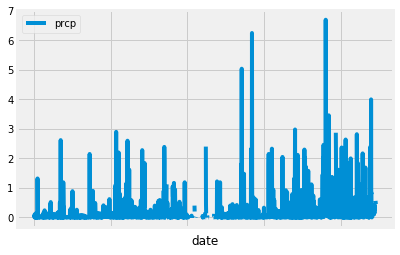

<Figure size 432x288 with 0 Axes>

In [18]:
# Sort the dataframe by date
#last_year_df = last_year_df.sort_values(by = "date")

# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot(x_compat = True)
plt.legend(last_year_df,loc=2)
plt.savefig("Images/Precipitation Plot.png")
plt.show()
plt.tight_layout()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


---

In [20]:
#Inspect the station table 
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [21]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [Station.station, func.count(Measurement.station)]
session.query(*sel).filter(Station.station == Measurement.station).group_by(Station.station).\
                            order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Join station table with measurement table on "station" column 
most_active_stations = engine.execute("SELECT station.station, COUNT(measurement.station) FROM station INNER JOIN \
               measurement ON station.station = measurement.station GROUP BY station.station ORDER BY \
               COUNT(measurement.station) DESC").fetchall()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
most_active_station = most_active_stations[0]

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*sel).filter(Measurement.station == most_active_station[0]).all()

[(54.0, 85.0, 71.66378066378067)]

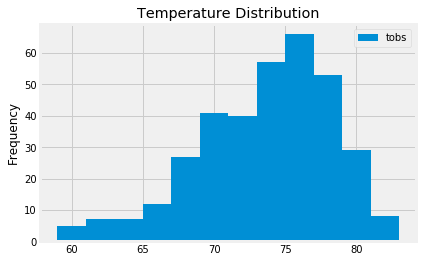

In [26]:
# Query to find the last data point in the database 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(last_date)

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print(query_date)

# Choose the station with the highest number of temperature observations.
most_active_station = most_active_stations[0][0]

# Query the last 12 months of temperature observation data for this station
last_year = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.date >= str(query_date), Measurement.station == most_active_station).all()
#print(last_year)

# Plot the results as a histogram
last_year_df = pd.DataFrame(last_year)
last_year_df = last_year_df.set_index("date")
last_year_df.head()

axarr = pd.DataFrame.hist(data = last_year_df, column = "tobs", bins = 12)
for ax in axarr.flatten():
    ax.set_title("Temperature Distribution")
    ax.set_ylabel("Frequency")

plt.legend(last_year_df,loc=1)
plt.savefig("Temperature Distribution Histogram.png")
plt.show()

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
yearly_temp = calc_temps('2016-08-23', '2017-08-23')
yearly_temp

[(58.0, 74.59058295964125, 87.0)]

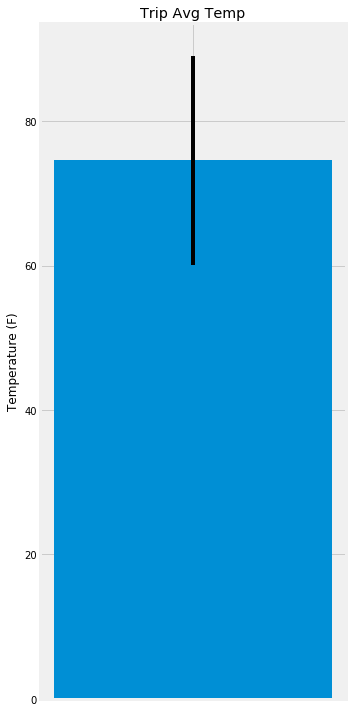

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Our Variables 
tmax = yearly_temp[0][2]
tmin = yearly_temp[0][0]
peak_to_peak = tmax - tmin # This will be our error line
tavg = yearly_temp[0][1] # This will be the height of our graph 

# Our Plot
fig, ax = plt.subplots(figsize = (5, 10)) # Create figure & axis objects 
ax.bar(x = 1, height = tavg, yerr = peak_to_peak/2, width = 0.4) # Plotting
ax.set_xticks([1]) # Set only 1 tick 
ax.set_xticklabels([""]) # "Remove" x-tick labels 

# Our "Labels"
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.savefig("Trip Avg Temp.png")
plt.tight_layout()

In [51]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
avg_yearly_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,\
                               Station.elevation, func.avg(Measurement.prcp)).\
        filter(Station.station == Measurement.station).\
        filter(Measurement.date >= '2016-08-23').\
        group_by(Station.station).order_by(func.avg(Measurement.prcp).desc()).all()
pd.DataFrame(avg_yearly_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude',  'Elevation', 'Avg. Precipitation (in.)'])

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044819
